# Assignment #2
### Gene Expression and Chromatin Accessibility

#### In this assignment, we will investigate gene expression and chromatin accessibility in healthy and cancerous blood cells.

The data we will look at is from a study of regulatory programs in mixed-phenotype acute leukemia (MPAL). The dataset used several -omic technologies, but we will specifically be investigating single cell RNA and single cell ATAC sequencing of healthy and MPAL cells in peripheral blood and bone marrow cells.

In this assignment, we're going to be looking for trends in gene expression and chromatin accessibility. More specifically, we'll investigate how chromatin accessibility of putative regulatory regions near genes are associated with expression of those genes.

Read the paper to learn more about the study [here](https://www.nature.com/articles/s41587-019-0332-7#Sec2). The data is located [here](https://github.com/GreenleafLab/MPAL-Single-Cell-2019?tab=readme-ov-file) (data is already included in the zip file, so don't worry about downloading it from there).

### First, let's load in our packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

In [ ]:
# You may need to edit this line if you can't load the dataset
os.chdir('/Users/vishal/Documents/TA_Class/assignments/Assignment2/Assignment2/') # TODO: comment this out before uploading

#### And then, our data

In [ ]:
scRNA_genes = pd.read_csv('./Data/scRNA-Healthy-genes-meta.csv', index_col=0)
scRNA_genes.index = scRNA_genes['gene_name']
scRNA_genes.head()

In [ ]:
scRNA_cells = pd.read_csv('./Data/scRNA-Healthy-cells-meta.csv', index_col=0)
scRNA_cells.head()

In [ ]:
scRNA_counts = pd.read_csv('./Data/scRNA-Healthy-counts.csv', index_col=0).T
scRNA_counts.head()

In [ ]:
scATAC_peaks = pd.read_csv('./Data/scATAC-healthy-peaks-meta.csv', index_col=0)
scATAC_peaks['peak_name'] = scATAC_peaks['seqnames']+'_'+scATAC_peaks['start'].astype('str')+'_'+scATAC_peaks['end'].astype('str')
scATAC_peaks = scATAC_peaks.set_index('peak_name')
scATAC_peaks.head()

In [ ]:
scATAC_cells = pd.read_csv('./Data/scATAC-healthy-cells-meta.csv', index_col=0)
scATAC_cells.head()

In [ ]:
scATAC_counts = pd.read_csv('./Data/scATAC-healthy-counts.csv', index_col=0).T
scATAC_counts.columns = scATAC_peaks.index
scATAC_counts.head()

In [ ]:
# This contains information about which scATAC peaks are associated with which genes. This was calculated by the authors of the paper
peak2genes = pd.read_table('./Data/Peak2Gene-Links-filt.tsv',sep='\t')
peak2genes.head()

## 1: Preprocessing

First, we're going to take a look at our dataset and get it ready for our analysis.

**A Note on the Dataset**

These data are very big! Originally it included over 50,000 cells and 20,000 genes (for scRNA-seq), and 70,000 cells and 500,000 peaks (for scATAC-seq)! This is too big to run on a personal computer, so we reduced the number of cells to ~10,000 for both datasets and reduced the scATAC-seq peaks to only include peaks that are significantly associated with genes using the `peak2genes` table. As a result, it is now small enough to run on a computer.

#### a) Overview of the Data

1. Read a little about the [study](https://www.nature.com/articles/s41587-019-0332-7#Sec2). What kind of tissue is our data from? What disease are we studying? Briefly describe their approach to studying this disease.

*ANSWER HERE*

2. Take a look at the datasets. We have one scRNA-seq dataset and one scATAC-seq dataset. For each dataset, what does a row represent? What does a column represent?

*ANSWER HERE*

3. For each dataset, what does a single entry of the matrix represent? How is this number derived from sequencing data for each modality? In other words, what is a single "count" in our scRNA-seq and in our scATAC-seq dataset? Be specific to how the data is actually generated.

*ANSWER HERE*

4. Finally, for the scATAC-seq data, we have one additional table called `peak2genes`. This is a table computed by the authors that links accessibility of certain chromatin regions to expression of certain genes. Why are the authors interested in identifying these links? Why are there multiple rows for the same gene? Why are there multiple genes associated with each peak?

*ANSWER HERE*

#### b) Preprocessing

1. In the paper, the authors mention that cells with fewer than 400 informative genes were filtered out of the scRNA-seq dataset. How would you confirm that the data is already filtered in this way?

In [ ]:
# CODE HERE

2. Looks like the both the scATAC and scRNA data are not normalized. Read the following excerpt from the paper about the scRNA-seq dataset, and normalize the scRNA-seq dataset using the method described.

    scRNA-seq: "We first log normalized the transcript counts by first depth normalizing to 10,000 and adding a pseudocount before a log2 transform (log2(counts per ten thousand transcripts + 1))"

   For the scATAC-seq dataset, use the same method (log2(counts per ten thousand + 1)) to normalize the data.

In [ ]:
# CODE HERE

**Sanity Check**: The sum of your normalized scRNA count matrix should be `36138590.428`, and the sum of your normalized scATAC count matrix should be `30263006.784`

## 2: Healthy Cells

In this section, we'll investigate the association between putative regulatory elements near genes and expression of those genes in various cell types. Recall the regulatory elements that aid in transcription of genes (figure). There are promoters, enhancers, and repressors. Let's investigate gene expression and uncover how various regulatory elements may associate with altered expression. We'll do this by looking at gene expression using scRNA-seq and chromatin accessibility using scATAC-seq.

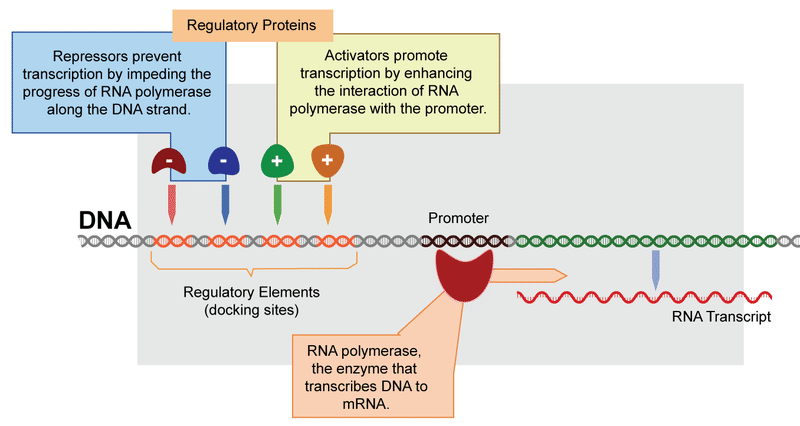

#### a) Cell Type Identification with Marker Genes

1. The authors of the dataset have already dimensionality reduced the data and stored their own UMAP embeddings in the scRNA_cells and scATAC_cells dataframes. In addition, they have already clustered the dataset using shared nearest neighbor clustering and already annotated these clusters by using marker genes to identify cell types. Firstly, plot the UMAP embeddings of each of these two datasets below in a UMAP_1 vs UMAP_2 scatterplot. Also, color this plot with the annotated clusters in the `BioClassification` column.

In [ ]:
# CODE HERE

2. In studies like this, cell types are often identified through unsupervised clustering followed by differential expression analysis to identify known cell type marker genes significantly associated with one (or a subset of) cluster(s). To see how this works, we'll just look at one example where we perform this analysis to find marker genes that separate T cell clusters from the remaining cells. To start, let's split our dataset into two groups, T-Cell and non-T-Cell. Use the list below to create a new column in the scRNA_cells dataframe that labels cells as either T-Cell or non-T-Cell.

   **Sanity Check** You should have 3620 T-cells and 6380 non-T-cells.

In [ ]:
t_cell_clusters = ['21_CD4.N2', '19_CD8.N', '24_CD8.CM', '22_CD4.M', '23_CD8.EM','20_CD4.N1']

In [ ]:
# CODE HERE

3. Now, let's do differential expression between these groups. CD3D is a T-Cell marker gene that encodes one chain of the CD3 T-Cell co-receptor protein complex. Perform differential expression using the logistic regression technique from class (and discussion) to identify the p-value and fold change of each gene in the dataset. Show that CD3D is differentially expressed in T-Cells.

   Use the function below to do this. In the end, you should have a p-value, and fold change for CD3D. Describe how this differential expression test works and indicate whether CD3D is upregulated or downregulated in T-Cells.

In [ ]:
def diff_exp(gene, A, B):
    N1 = A.shape[0]
    N2 = B.shape[0]
    logr_labels = np.concatenate((np.ones(N1), np.zeros(N2)), axis=0)
    logr = LogisticRegression(C=1000)
    p_of_1 = N1 / float(N1 + N2)
    llnull = (N1 + N2) * (p_of_1 * np.log(p_of_1) + (1 - p_of_1) * np.log(1 - p_of_1))
    X1 = np.asarray(A[gene]).reshape(-1, 1)
    X2 = np.asarray(B[gene]).reshape(-1, 1)
    c = np.concatenate([X1, X2])
    logr.fit(c, logr_labels)
    pred = np.array(logr.predict_proba(c)[:, 1])
    gene_score = log_loss(logr_labels, pred)
    llf = -gene_score * (N1 + N2)
    llr = llf - llnull
    llr_pval = stats.chi2.sf(2 * llr, 1)  # survival function defined as 1-cdf
    fc = np.mean(A[gene]) / np.mean(B[gene])
    return logr, llr_pval, fc

In [ ]:
# CODE HERE

*ANSWER HERE*

#### b) Investigating the Relationship between Gene Expression and Chromatin Accessibility

1. Great, now we have shown that CD3D is differentially expressed in T-Cells. Now, let's investigate how expression of CD3D is associated with various chromatin regions that regulate CD3D, and how expression and accessibility varies between cell types.

   To start, color your scRNA-seq UMAP plots with the expression of this gene. In addition, it may be a little difficult to visualize which cell types CD3D is expressed in from the UMAP plots. Thus, also plot the expression of CD3D in the various cell types using a violin plot.

    Your violin plot should look like this (but with different numbers and labels)
   <img src='./violin_ex.png' alt='violin_ex' width=500>

In [ ]:
# CODE HERE

2. Using the plots from above, which clusters have high expression of the gene?

*ANSWER HERE*

3. Now we know the cell types in which CD3D is expressed. Let's now investigate what role chromatin accessibility plays in the expression of this gene in various cell types. First, use the `peaks2gene` dataframe to identify all of the peaks associated with CD3D.

   **Sanity Check**: You should have 5 peaks

In [ ]:
# CODE HERE

4. Now, let's color the signal of each of the peaks identified in the last question over the scATAC-seq UMAP plot. In addition, print the mean ATAC signal of each peak for each cell type. We suggest using the `groupby` and `describe` methods to get summary statistics for each cell type. It looks like it's easier to visualize these data when looking at summary statistics than in a colored UMAP figure. Why is this the case?

In [ ]:
# CODE HERE

*ANSWER HERE*

5. In which cell types are each of these peaks occurring? There should be one peak that is different from the others. Which peak is this?

*ANSWER HERE*

6. What do you think is the role of the segment of DNA at the peak that is different? Why? What do you think is the role of the DNA segment at the other peaks?

*ANSWER HERE*

## 3: Mixed-Phenotype Acute Leukemia (MPAL) Cells

Great! In the last section we were able to learn about how different regulatory elements can have variable associations with gene epxression, and how chromatin accessibility patterns allows the cell to regulate gene expression. Now, we're interested in looking at how gene expression changes in our disease cells, and how that might be impacted by chromatin accessibility. Let's see if we can uncover something from the data!

#### Import the data

Let's load in the scRNA and scATAC-seq data for the diseased cells. Again, in order to make this manageable for a personal computer, I sampled 5000 MPAL cells for both datasets, and I am using the same filtered peaks from the previous scATAC-seq dataset.

In [ ]:
scRNA_MPAL_genes = pd.read_csv('./Data/scRNA-MPAL-genes-meta.csv', index_col=0)
scRNA_MPAL_genes = scRNA_MPAL_genes.set_index('gene_name')
scRNA_MPAL_genes.head()

In [ ]:
scRNA_MPAL_cells = pd.read_csv('./Data/scRNA-MPAL-cells-meta.csv', index_col=0)
scRNA_MPAL_cells.head()

In [ ]:
scRNA_MPAL_counts = pd.read_csv('./Data/scRNA-MPAL-counts.csv', index_col=0).T
scRNA_MPAL_counts.columns = scRNA_genes.index
scRNA_MPAL_counts.head()

In [ ]:
scATAC_MPAL_peaks = pd.read_csv('./Data/scATAC-MPAL-peaks-meta.csv', index_col=0)
scATAC_MPAL_peaks['peak_name'] = scATAC_MPAL_peaks['seqnames']+'_'+scATAC_MPAL_peaks['start'].astype('str')+'_'+scATAC_MPAL_peaks['end'].astype('str')
scATAC_MPAL_peaks = scATAC_MPAL_peaks.set_index('peak_name')
scATAC_MPAL_peaks.head()

In [ ]:
scATAC_MPAL_cells = pd.read_csv('./Data/scATAC-MPAL-cells-meta.csv', index_col=0)
scATAC_MPAL_cells.head()

In [ ]:
scATAC_MPAL_counts = pd.read_csv('./Data/scATAC-MPAL-counts.csv', index_col=0).T
scATAC_MPAL_counts.columns = scATAC_MPAL_peaks.index
scATAC_MPAL_counts.head()

#### a) Investigating MPAL Cells

1. Let's start our analysis of MPAL cells by first normalizing our data in the same way as the healthy cells. Normalize the data in the way described below:

    scRNA-seq, follow the paper: "We first log normalized the transcript counts by first depth normalizing to 10,000 and adding a pseudocount before a log2 transform (log2(counts per ten thousand transcripts + 1))"

   For the scATAC-seq dataset, use the same method (log2(counts per ten thousand + 1)) to normalize the data.

**Sanity Check**: The sum of your normalized MPAL scRNA count matrix should be `18933584.388`, and the sum of your normalized MPAL scATAC count matrix should be `17343784.810`.


In [ ]:
# CODE HERE

2. Let's take a look at the CD69, a gene that was investigated in detail in the paper. First, let's plot CD69 expression in the various types of healthy cells to see what CD69 expression should look like. Use a violinplot to plot this for each cell type.

In [ ]:
# CODE HERE

3. Because the healthy cells have more specific cell types than the MPAL cells, it may be difficult to visualize the relationships in the data. Below, we have consolidated the healthy cell types into fewer categories, located in the `type` column for each dataset. Now, plot CD69 expression using violin plots like above with these new cell types. In which healthy cell types is CD69 expressed?

In [ ]:
clusters = {
    'erythroid': ['02','03'],
    'lymphoid': ['06','15','16','17','26'],
    'myeloid': ['08', '09', '07', '12', '11', '10', '14', '13', '18'],
    'progenitor': ['04','01','05'],
    'T/NK': ['25','24','22','23','20','19','21']
}

In [ ]:
scRNA_cells['type'] = ''
scATAC_cells['type'] = ''
for type, cluster in clusters.items():
    scRNA_cells.loc[scRNA_cells['BioClassification'].str[0:2].isin(cluster),'type'] = type
    scATAC_cells.loc[scATAC_cells['BioClassification'].str[0:2].isin(cluster),'type'] = type

In [ ]:
# CODE HERE

*ANSWER HERE*

4. Now, let's see how the various scATAC peaks for CD69 are associated with gene expression for CD69. First, identify which peaks are associated with CD69 expression. Print the names of these peaks.

   **Sanity Check**: You should have 4 peaks

In [ ]:
# CODE HERE

5. Now, investigate each of these peaks using the same consolidated cell types from earlier by printing the mean signal from each cell type for each peak. Again, we suggest using the `groupby` and `describe` functions to print summary statistics for each peak. How are these peaks associated with CD69 expression? What kind of regulatory elements for CD69 could be located at each peak?

In [ ]:
# CODE HERE

*ANSWER HERE*

6. Great, we have characterized expression and regulation of CD69 in healthy cells. Now, let's look at MPAL cells. The authors identified cell type classifications for the cancerous cells based on how similar they were to the various healthy cell types. These classifications are stored in the `ProjectClassification` column in our scATAC_cells dataframe. Use this column to plot CD69 expression in the cancer cell-type classifications using a violinplot.

   What is the overall trend of CD69 expression in healthy vs MPAL cells (up/down/the same)? For each of the analogous cell types, what is the trend in MPAL vs healthy cells? How is CD69 expressed differently between the cell types?

In [ ]:
# CODE HERE

*ANSWER HERE*

7. Let's look at how chromatin accessibility is different in healthy vs MPAL cells. Let's calculate the average signal of each chromatin peak for each MPAL cell type. Like before, print the mean ATAC signal for each cell type, or use the `groupby` and `describe` functions to print the summary statistics for each peak. For each peak, what is the overall trend in how chromatin accessibility is affected by MPAL? For each of the analogous cell types, how is chromatin accessibility different in cancer cells? Finally, how does this validate our conclusions when looking at gene expression, with regards to the regulatory elements at each peak?

In [ ]:
# CODE EHRE

*ANSWER HERE*

Great! Now we have learned about how CD69 expression and accessibility changes due to cancer. This gene was particularly interesting for the authors as it falls within a list of many genes that they found were proximal to regulatory elements linked to the RUNX1 transcription factor in MPAL cells. This means that increased accessibility of sites that bind to this transcription factor could lead to increased expression of genes like CD69. This could help us understand regulatory mechanisms in MPAL.

## 4: Conclusions and Future Steps

Great! We were able to learn about how gene expression and chromatin accessibility are associated in healthy cells, and we learned more about what changes to gene expression and chromatin accessibility leukemia can be associated with. Now, let's think about conclusions and future steps.

1. In this analysis, we are able to deduce associations in the data, but we do not learn anything about causality (e.g. X causes Y). Why is this? What kind of analysis could allow us to identify causal relationships in the data?

2. From our findings, what kind of questions or data could be interesting for us to learn more about Mixed Phenotype Acute Leukemia?

## The end!